In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import importlib

from kaggle_submit import submit_to_kaggle
from helpers import *
from utils.globals import *
from utils.distribution_statistics import *

train_file = "kaggle_data/X_train.h5/X_train.h5"
test_file = "kaggle_data/X_test.h5/X_test.h5"

h5_train = h5py.File(train_file, mode='a')
h5_test = h5py.File(test_file, mode='a')

y_train = pd.read_csv("kaggle_data/y_train.csv", index_col=0, squeeze=True)
y_train_arr = y_train.to_numpy()

# MAKE CUSTOM FEATURES

from additional_features.make_features import make_all_features
make_all_features(h5_train, h5_test, n_chunks=10, verbose=True, overwrite=False)

from additional_features.make_features import _create_eeg_mean, _create_log_energy, _create_log_modulus
for h5_file in (h5_train, h5_test):
    for creation_function in [_create_eeg_mean, _create_log_energy, _create_log_modulus]:
        print(creation_function.__name__)
        creation_function(h5_file, n_chunks=100, verbose=True, overwrite=False)

from objects import *


_create_eeg_mean
_create_log_energy
_create_log_modulus
_create_pulse_max_log_energy_and_freq
_create_speed_and_acceleration
_create_time_features
_create_eeg_mean
_create_log_energy
_create_log_modulus
_create_eeg_mean
_create_log_energy
_create_log_modulus


In [9]:
features_df = pd.DataFrame(list(set(h5_train.keys()) - set(IRRELEVANT_FEATURES)), columns=["Feature"])
features_df.loc[:, "Dim"] = features_df['Feature'].apply(lambda x: h5_train[x][0].shape[0])
features_df.sort_values(by=["Dim", "Feature"])

import re

BAND_LOG_ENERGY_FEATURES = [feat for feat in FEATURES if re.search("(?:(?:alpha)|(?:beta)|(?:delta)|(?:theta)){1}.*_logE", feat)]

SLEEP_FEATURES = [feat for feat in FEATURES if re.search('sleep.*[^(?:logmod)]', feat)]

LOGMOD_FEATURES = [feat for feat in FEATURES if re.search('.*_logmod', feat)]

TIME_FEATURES

OTHER_FEATURES = ["pulse_max_freq", "pulse_max_logE"]

_features = sum([BAND_LOG_ENERGY_FEATURES, SLEEP_FEATURES, LOGMOD_FEATURES, TIME_FEATURES, OTHER_FEATURES], [])
print(set(_features) - set(FEATURES), set(FEATURES) - set(_features))
assert sorted(_features) == sorted(FEATURES)

def eeg_mean_filter(*args):
    eeg_elem_filter_ = lambda x: not re.search("eeg_mean", x)
    return [[x for x in arg if eeg_elem_filter_(x)] for arg in args]
    

BAND_LOG_ENERGY_FEATURES_OLD, SLEEP_FEATURES_OLD, LOGMOD_FEATURES_OLD, TIME_FEATURES_OLD, OTHER_FEATURES_OLD = \
    eeg_mean_filter(BAND_LOG_ENERGY_FEATURES, SLEEP_FEATURES, LOGMOD_FEATURES, TIME_FEATURES, OTHER_FEATURES)

print(BAND_LOG_ENERGY_FEATURES_OLD)

set() set()
['beta_eeg_7_logE', 'alpha_eeg_5_logE', 'beta_eeg_6_logE', 'theta_eeg_6_logE', 'delta_eeg_3_logE', 'beta_eeg_1_logE', 'beta_eeg_4_logE', 'theta_eeg_2_logE', 'theta_eeg_1_logE', 'alpha_eeg_1_logE', 'delta_eeg_1_logE', 'delta_eeg_7_logE', 'alpha_eeg_2_logE', 'alpha_eeg_3_logE', 'delta_eeg_6_logE', 'theta_eeg_4_logE', 'theta_eeg_7_logE', 'beta_eeg_5_logE', 'beta_eeg_3_logE', 'alpha_eeg_4_logE', 'delta_eeg_2_logE', 'delta_eeg_4_logE', 'alpha_eeg_7_logE', 'theta_eeg_3_logE', 'alpha_eeg_6_logE', 'theta_eeg_5_logE', 'beta_eeg_2_logE', 'delta_eeg_5_logE']


In [98]:
def make_input_default(h5_file):
    df_bandlog = make_input_new(
        h5_file,
        features=BAND_LOG_ENERGY_FEATURES_OLD,
        rescale_by_subject=False,
        moments=[1],
        #pre_op=np.exp,
        #pre_op_name="energy"
    )
    
    df_sleep = make_input_new(
        h5_file,
        features=SLEEP_FEATURES_OLD,
        rescale_by_subject=False,
        moments=[1]
    )
    
    ## LOGMOD RENAME COLUMNS
    
    df_logmod = make_input_new(
        h5_file,
        features=LOGMOD_FEATURES_OLD,
        rescale_by_subject=False,
        # moments=[1],
        quantiles_inv=[0.1, 0.3, 0.5, 0.7, 0.9],
        #quantiles=[0.1, 0.5, 0.9],
        diff_orders=[0],
        #interquantiles=[(0.1, 0.9), (0.3, 0.7)],
        interquantiles_inv=[(0.1, 0.9), (0.3, 0.7)],
        #pre_op=lambda x: np.exp(2 * x),
        #pre_op_name="energy"
    )
    
   # cols_no_rescale = [(col[0] + "_no_rescale", *col[1:]) for col in df_logmod_no_rescale.columns]
   # df_logmod_no_rescale.columns = pd.MultiIndex.from_tuples(cols_no_rescale)
    
   # df_logmod_with_rescale = make_input_bis(
   #     h5_file,
   #     features=LOGMOD_FEATURES,
   #     rescale=True,
   #     moments=[1, 2],
   #     quantiles=[0.05, 0.95],
   #     quantiles_inv=[0.1, 0.3, 0.5, 0.7, 0.9],
   #     diff_orders=[0, 1],
   #     pre_op=lambda x: np.exp(2 * x),
   #     pre_op_name="energy"
   # )
    
   # cols_with_rescale = [(col[0] + "_with_rescale", *col[1:]) for col in df_logmod_with_rescale.columns]
   # df_logmod_with_rescale.columns = pd.MultiIndex.from_tuples(cols_with_rescale)
    
    ## END LOGMOD RENAME COLUMNS
    
    
    df_time_diff_0 = make_input_new(
        h5_file,
        features=TIME_FEATURES_OLD,
        rescale_by_subject=False,
        # moments=[1, 2],
        quantiles=[1e-4, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99, 1-1e-4],
        interquantiles=[(0.1, 0.9), (0.3, 0.7)],
        diff_orders=[0]
    )
    
    #df_time_diff_1 = make_input_new(
    #    h5_file,
    #    features=TIME_FEATURES,
    #    rescale_by_subject=False,
    #    # moments=[1, 2],
    #    quantiles=[1e-4, 1-1e-4],
    #    diff_orders=[1]
    #)
    
    #df_pulse_max_freq = make_input_new(
    #    h5_file,
    #    features=["pulse_max_freq"],
    #    rescale_by_subject=True,
    #    moments=[1],
    #)
    
    #df_pulse_max_logE = make_input_new(
    #    h5_file,
    #    features=["pulse_max_logE"],
    #    rescale_by_subject=False,
    #    moments=[1],
        #pre_op=np.exp,
        #pre_op_name="energy"
    #)
    
    
    return pd.concat([
        df_bandlog,
        df_sleep,
        df_logmod, 
        #df_logmod_with_rescale, 
        df_time_diff_0,
        #df_time_diff_1,
        #df_pulse_max_freq,
        #df_pulse_max_logE,
        ],
        axis=1)

def shift_and_fill(df, shift):
    shifted_df = df.shift(shift)
    if shift > 0:
        shifted_df.bfill(inplace=True)
    elif shift < 0:
        shifted_df.ffill(inplace=True)
    return shifted_df


def roll_and_concat(df, shifts_range):
    return pd.concat(map(lambda shift: shift_and_fill(df, shift), shifts_range), 
                     axis=1, keys=shifts_range)    
    
def concat_windows(h5_file, df, shifts):
    df = df.groupby(h5_file["index"][:], as_index=False).apply(roll_and_concat, shifts_range=shifts)
    return df
    
def make_input_default_test(h5_file):
    return make_input_new(h5_file, ["eeg_1", "eeg_2"], moments=[1])

def make_input_default_rolling(h5_file, shifts):
    """
    !!! not suited for pca because columns have 3 levels
    """
    df = make_input_default(h5_file)
    df_with_window = concat_windows(h5_file, df, shifts)
    return df_with_window


In [99]:
X_train_raw, X_test_raw = make_input_default(h5_train), make_input_default(h5_test)

In [100]:
train_ids = get_subject_ids(h5_train)
train_train_ids, train_val_ids = train_ids[:28], train_ids[28:]

X_train_train = X_train_raw.loc[subjects_ids_to_indexers(h5_train, train_train_ids, as_indices=True), :]
y_train_train = y_train_arr[subjects_ids_to_indexers(h5_train, train_train_ids, as_indices=True)]

X_train_val = X_train_raw.loc[subjects_ids_to_indexers(h5_train, train_val_ids, as_indices=True), :]
y_train_val = y_train_arr[subjects_ids_to_indexers(h5_train, train_val_ids, as_indices=True)]

"""
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

scaler_ = MinMaxScaler()
pca_ = PCA(0.99)

X_train_train = pca_.fit_transform(scaler_.fit_transform(X_train_train))
X_train_val = pca_.transform(scaler_.transform(X_train_val))
X_test = pca_.transform(scaler_.transform(X_test_raw))
"""
def subjects_ids_col(h5_file):
    return h5_file["index"][:]

def concat_windows(arr, subjects_ids, h5_file, shifts): # subjects_ids must be sorted
    sid_col = subjects_ids_col(h5_file)
    sid_col = sid_col[np.isin(sid_col, subjects_ids)]
    df = pd.DataFrame(arr)
    
    return df.groupby(sid_col).apply(roll_and_concat, shifts_range=shifts)

shifts = [-1, 0, 1]
X_train_train_rolled = concat_windows(X_train_train, train_train_ids, h5_train, shifts)
X_train_val_rolled = concat_windows(X_train_val, train_val_ids, h5_train, shifts)




In [191]:
from sklearn.ensemble import RandomForestClassifier

estimator_rf = RandomForestClassifier(
    # verbose=1,
    random_state=1,
    # max_depth=10,
    n_estimators=275, # default=100
    #min_samples_leaf=10,
    #min_weight_fraction_leaf= 0.01,
    max_features="auto",
    criterion="gini"
)

estimator_rf.fit(X_train_train_rolled, y_train_train)

train_score_rf = custom_score(estimator_rf.predict(X_train_train_rolled), y_train_train)
val_score_rf = custom_score(estimator_rf.predict(X_train_val_rolled), y_train_val)

In [186]:
print(train_score_rf)
print(val_score_rf)

1.0
0.7607815353446564


In [192]:
print(train_score_rf)
print(val_score_rf)

1.0
0.7607815353446564


| Random Forest Params | Time Features Quantiles | Time Features Moments | Sleep Features | Pulse Freq (f_max, A_max) | Shifts | Comments | Training Score | Validation Score |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| - | 0.1, 0.5, 0.9 | - | No | - | 0 | - | 1| 0.67|
| - | 0.1, 0.5, 0.9 | - | Yes | - | 0 | - | 1 | 0.69|
| - | 0.1, 0.5, 0.9 | - | Yes | - | -1, 0, 1 | - | 1 | 0.7|
| - | 0.01, 0.1, 0.5, 0.9, 0.99 | - | Yes | - | -1, 0, 1 | - | 1| 0.7  |
| `min_samples_leaf=10` | 0.01, 0.1, 0.5, 0.9, 0.99 | - | Yes | - | -1, 0, 1 | - | 0.89 | 0.69  |
| `min_samples_leaf=10` | 0.01, 0.1, 0.5, 0.9, 0.99 | 1, 2 | Yes | - | -1, 0, 1 |  - | 0.89 | 0.69  |
| - | 0.01, 0.1, 0.5, 0.9, 0.99 | 1, 2 | Yes | - | -1, 0, 1 |  - | 1 | 0.697  |
| - | 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99 | - | Yes | - | -1, 0, 1 |  - | 1 | 0.708  |
| - | 0.01, DECILES, 0.99 | - | Yes | - | -1, 0, 1 |  - | 1 | 0.709  |
| `min_samples_leaf=10` | 0.01, DECILES, 0.99 | - | Yes | - | -1, 0, 1 |  - | 0.89 | 0.697 |
| `min_samples_leaf=10` | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 |  - | 0.89 | 0.699 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 |  - | 1 | 0.713929 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | Yes | -1, 0, 1 |  - | 1 | 0.7 |
| `min_samples_leaf=10` | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | Yes | -1, 0, 1 | - | 0.89 | 0.697 |
| `min_samples_leaf=10` | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | Pulse Only | -1, 0, 1 | - | 0.89 | 0.7 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | Pulse Only | -1, 0, 1 |  - | 1 | 0.7055 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 | - |  1 | 0.7055 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX + derivee 0.5 | - | Yes | - | -1, 0, 1 |  - | 1 | 0.708 |
| `min_samples_leaf=10` | MIN, 0.01, ODD_DECILES, 0.99, MAX + derivee 0.5 | - | Yes | - | -1, 0, 1 |  - | 0.89 | 0.700|
| `min_samples_leaf=10` | MIN, 0.01, ODD_DECILES, 0.99, MAX + derivee MIN, MAX | - | Yes | - | -1, 0, 1 | - | 0.89| 0.7 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX + derivee MIN, MAX | - | Yes | - | -1, 0, 1 | - | 1| 0.703|
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 | `bandlog rescaled`| 1| 0.665 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 | `quantiles_inv = 10%, 90% for logmod`| 1| 0.7165 |
| `min_samples_leaf=10` | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 | `quantiles_inv = 10%, 90% for logmod`| ? | 0.70 < x < 0.71 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 | `quantiles_inv = ODD_DECILES for logmod`| 1 | 0.7371780518172594 |
| `min_samples_leaf=10` | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 | `quantiles_inv = ODD_DECILES for logmod`| 0.898 | 0.721 |
| - | MIN, 0.01, ODD_DECILES, 0.99, MAX | - | Yes | - | -1, 0, 1 | `quantiles_inv = ODD_DECILES for logmod; eeg_mean only`| 1 | 0.645 |

In [194]:
test_ids = get_subject_ids(h5_test)
X_test_rolled = concat_windows(X_test_raw, test_ids, h5_test, shifts)
y_pred = estimator_rf.predict(X_test_rolled)
#submit_to_kaggle(y_pred, h5_test, fname='rf_best_2021-01-02.csv', msg="")

New submission file at submissions/rf_best_2021-01-02.csv


In [163]:
from sklearn.ensemble import AdaBoostClassifier

estimator_ab = AdaBoostClassifier(
    base_estimator = estimator_rf,
    # verbose=1,
    random_state=1,

    n_estimators=30, # default=100
    #learning_rate=0.5
)

estimator_ab.fit(X_train_train_rolled, y_train_train)

train_score_ab = custom_score(estimator_ab.predict(X_train_train_rolled), y_train_train)
val_score_ab = custom_score(estimator_ab.predict(X_train_val_rolled), y_train_val)

In [164]:
print(train_score_ab)
print(val_score_ab)

0.9235468115831919
0.7406978954377438


In [160]:
test_ids = get_subject_ids(h5_test)
X_test_rolled = concat_windows(X_test_raw, test_ids, h5_test, shifts)
y_pred_ab = estimator_ab.predict(X_test_rolled)
#submit_to_kaggle(y_pred, h5_test, fname='ab_best_2021-01-02.csv', msg="")

New submission file at submissions/ab_best_2021-01-02.csv


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

scaler_ = MinMaxScaler()

X_train_train_rolled_svc = scaler_.fit_transform(X_train_train_rolled) 
X_train_val_rolled_svc = scaler_.transform(X_train_val_rolled)
X_test_rolled_svc = scaler_.transform(X_test_rolled)


estimator_svc = SVC(verbose=1, kernel='rbf', C=1, max_iter=1000, random_state=1)
estimator_svc.fit(X_train_train_rolled_svc, y_train_train)

train_score_svc = custom_score(estimator_svc.predict(X_train_train_rolled_svc), y_train_train)
val_score_svc = custom_score(estimator_svc.predict(X_train_val_rolled_svc), y_train_val)

In [44]:
X_test_rolled.shape

(24980, 63)

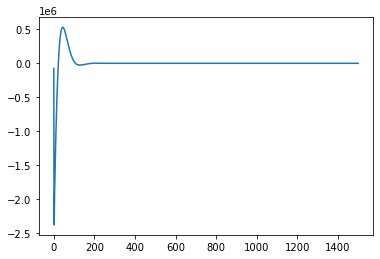

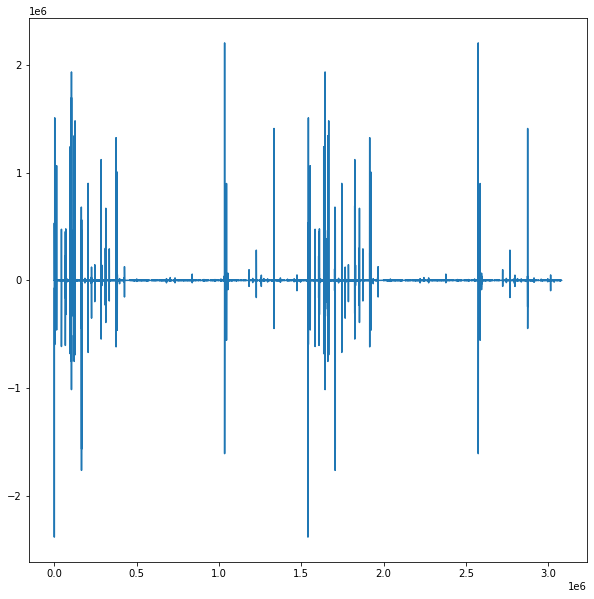

In [126]:
#plt.figure(figsize=(10,10))
plt.plot(h5_train['eeg_1'][0])
plt.show()
start,end = get_subject_boundaries(h5_train, 0, ready_to_use=False)
night=h5_train['eeg_1'][slic]
for i in range(start,end+1):
    night = np.concatenate((night,h5_train['eeg_1'][i]), axis=None)
plt.figure(figsize=(10,10))
plt.plot(night)
plt.show()


In [130]:
sleep_stages = y_train_arr

def mean_stat(feat):
    mean_samples = np.mean(h5_train[feat][:], axis=1)
    df = pd.DataFrame(mean_samples, columns=[feat], index=y_train_arr)
    return df.groupby(df.index).agg([np.mean, np.std])

def quantile_stat(feat, func_arr=lambda x: np.mean(x, axis=1), quantiles=np.linspace(0.1, 0.9, 9).round(2)):
    samples_stat = func_arr(h5_train[feat][:])
    df = pd.DataFrame(samples_stat, columns=[feat], index=y_train_arr)
    quantiles_df = df.groupby(df.index).apply(lambda x: np.quantile(x, q=quantiles))
    quantiles_df = np.array(quantiles_df.tolist())
    quantiles_df = pd.DataFrame(quantiles_df, columns=[str(q) for q in quantiles])
    return quantiles_df

def plot_quantile_stat(features, func_arr, func_name, quantiles, logscale=False):
    for feat in features:
        qstat = quantile_stat(feat, func_arr, quantiles=quantiles)
        # print(qstat)
        for i in range(len(qstat.columns)):
            plt.scatter(qstat.index, qstat.values[:, i])
        plt.title(feat + f" quantiles 0.25, 0.5, 0.75")
        if logscale:
            plt.yscale("log")
        plt.show()

def create_quantile_plot():
    pass
        


# z = quantile_stat("eeg_1")

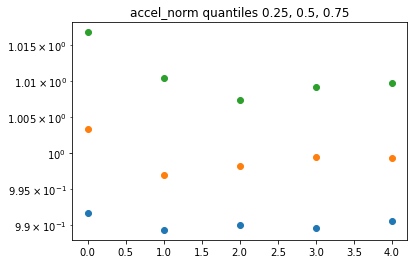

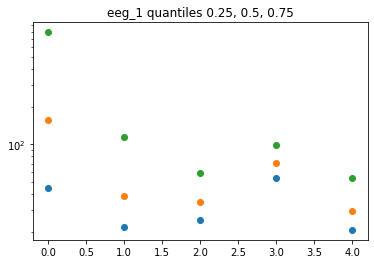

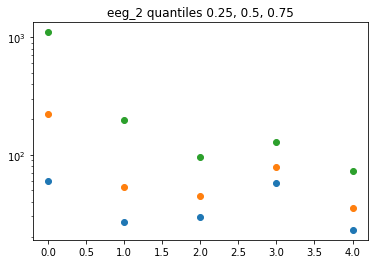

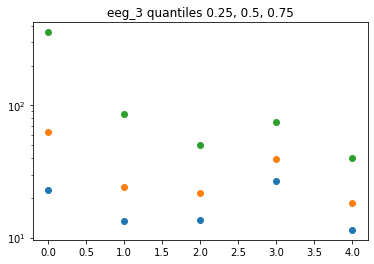

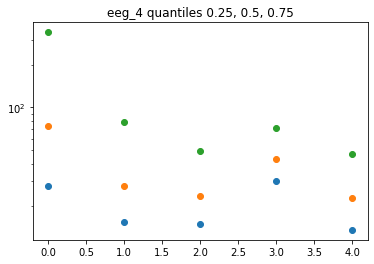

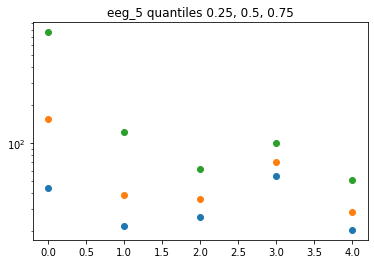

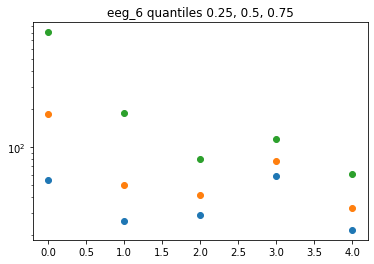

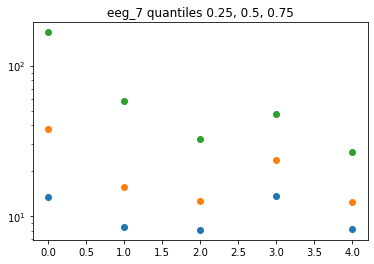

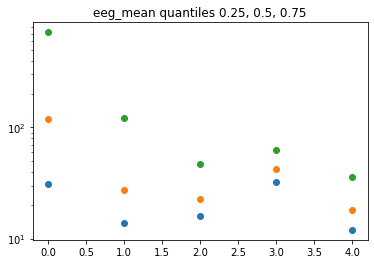

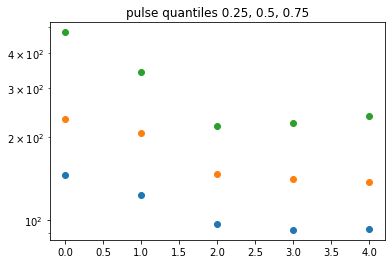

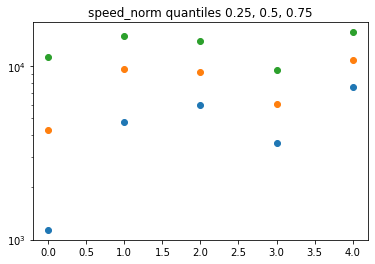

In [131]:
def moment(arr, order, diff_order):
    return np.mean(differentiate(arr, diff_order) ** order, axis=1)

# f = lambda x: moment(x, order=4, diff_order=0)
# f = lambda x: np.quantile(x, q=0.9, axis=1) - np.quantile(x, q=0.1, axis=1)
f = lambda x: np.quantile(x, q=0.95, axis=1)
plot_quantile_stat(TIME_FEATURES, f, "", quantiles=[0.25, 0.5, 0.75], logscale=True)